<a href="https://colab.research.google.com/github/Deepakkumar5570/Research_work_Projects/blob/main/SugarCane_Notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import zipfile, os

# Path to zip
zip_path = "/content/archive (3).zip"

# Safer extract path
extract_path = "/content/dataset"

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraction completed!")
print("Files in dataset directory:", os.listdir(extract_path))


BadZipFile: File is not a zip file

In [5]:
import os

zip_path = "/content/archive (3).zip"
print("File exists:", os.path.exists(zip_path))
print("File size:", os.path.getsize(zip_path), "bytes")


File exists: True
File size: 144703488 bytes


In [10]:
!unzip -q "/content/archive (3).zip" -d "/content/dataset"

import os
print(os.listdir("/content/dataset"))



['Rust', 'Healthy', 'Mosaic', 'RedRot', 'Yellow']


In [11]:
import glob

# Count all images (jpg, png, jpeg etc.)
image_files = glob.glob(extract_path + "/**/*.jpg", recursive=True) + \
              glob.glob(extract_path + "/**/*.png", recursive=True) + \
              glob.glob(extract_path + "/**/*.jpeg", recursive=True)

print(f"Total images found: {len(image_files)}")

# Show first 5 image paths
print(image_files[:5])


Total images found: 2521
['/content/dataset/Rust/rust (155).jpeg', '/content/dataset/Rust/rust (90).jpeg', '/content/dataset/Rust/rust (364).jpeg', '/content/dataset/Rust/rust (444).jpeg', '/content/dataset/Rust/rust (236).jpeg']


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import os


In [ ]:
# Paths
data_dir = "/content/dataset"

# Image transformations (augmentation for training)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # Imagenet mean
                         [0.229, 0.224, 0.225])  # Imagenet std
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Datasets
train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(root=data_dir, transform=test_transforms)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class names
class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer (for 5 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [ ]:
num_epochs = 10
train_losses, test_losses, accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    test_losses.append(val_loss / len(test_loader))
    accuracies.append(acc)

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"Train Loss: {running_loss/len(train_loader):.4f} "
          f"Val Loss: {val_loss/len(test_loader):.4f} "
          f"Val Acc: {acc:.2f}%")


Epoch 1/10 Train Loss: 1.2626 Val Loss: 1.0013 Val Acc: 65.65%
Epoch 2/10 Train Loss: 0.8897 Val Loss: 0.7922 Val Acc: 72.87%
Epoch 3/10 Train Loss: 0.7514 Val Loss: 0.6422 Val Acc: 80.36%
Epoch 4/10 Train Loss: 0.6752 Val Loss: 0.6465 Val Acc: 77.47%
Epoch 5/10 Train Loss: 0.6222 Val Loss: 0.5434 Val Acc: 82.15%
Epoch 6/10 Train Loss: 0.6075 Val Loss: 0.5218 Val Acc: 82.71%
Epoch 7/10 Train Loss: 0.5437 Val Loss: 0.5314 Val Acc: 82.15%
Epoch 8/10 Train Loss: 0.5514 Val Loss: 0.4797 Val Acc: 83.86%
Epoch 9/10 Train Loss: 0.5295 Val Loss: 0.4795 Val Acc: 83.58%
Epoch 10/10 Train Loss: 0.5149 Val Loss: 0.4796 Val Acc: 83.34%


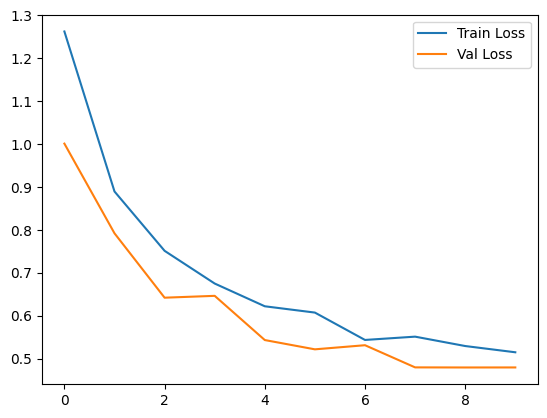

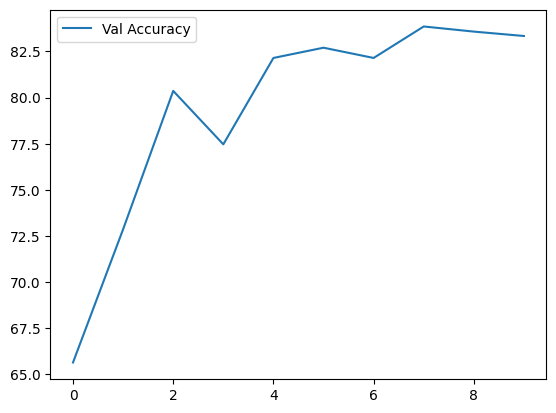

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Val Loss')
plt.legend()
plt.show()

plt.plot(accuracies, label='Val Accuracy')
plt.legend()
plt.show()


In [ ]:
from PIL import Image

def predict_image(image_path, model):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    transform = test_transforms
    img_t = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_t)
        _, pred = torch.max(outputs, 1)

    return class_names[pred.item()]

# Example
print(predict_image("/content/dataset/Mosaic/mosaic (103).jpeg", model))


Mosaic


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import seaborn as sns


In [ ]:
y_true = []
y_pred = []
y_prob = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Predictions
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

        # Probabilities (for ROC/AUC)
        probs = torch.softmax(outputs, dim=1)
        y_prob.extend(probs.cpu().numpy())


In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

     Healthy       0.94      0.75      0.83       522
      Mosaic       0.76      0.85      0.80       462
      RedRot       0.77      0.90      0.83       518
        Rust       0.84      0.92      0.88       514
      Yellow       0.90      0.75      0.82       505

    accuracy                           0.83      2521
   macro avg       0.84      0.83      0.83      2521
weighted avg       0.84      0.83      0.83      2521



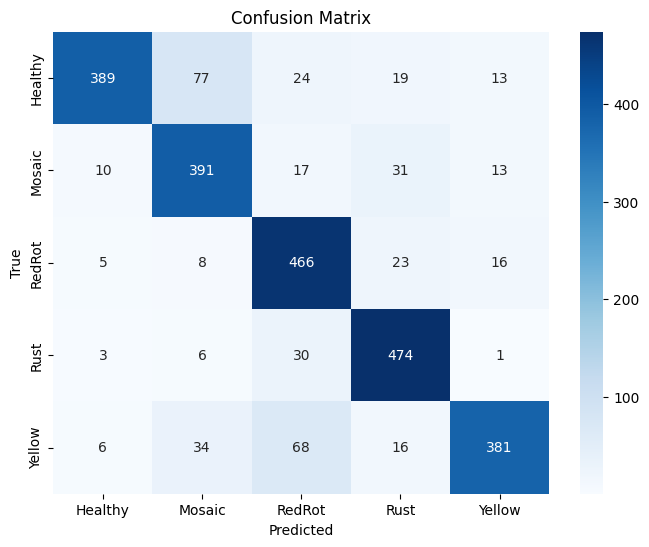

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Overall AUC Score: 0.9764


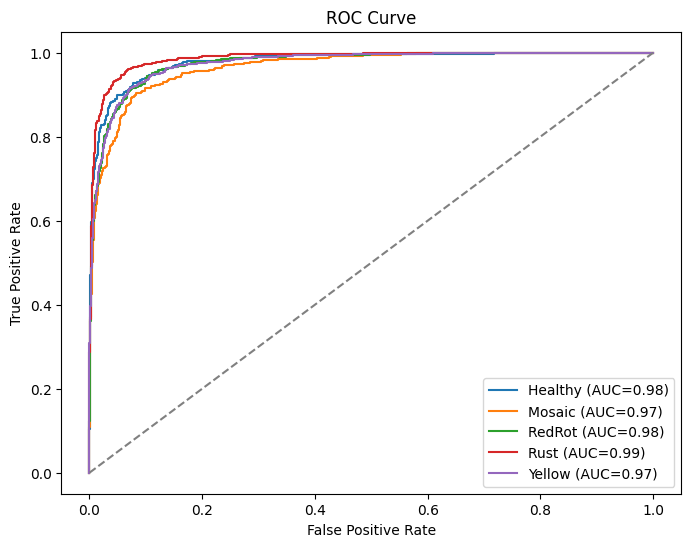

In [ ]:
from sklearn.preprocessing import label_binarize

# Binarize labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
n_classes = y_true_bin.shape[1]

# AUC score
auc_score = roc_auc_score(y_true_bin, y_prob, multi_class="ovr")
print(f"Overall AUC Score: {auc_score:.4f}")

# Plot ROC Curve for each class
plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], np.array(y_prob)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


#Architecture

1. Imports & Config
   └── Device setup, paths, class names

2. Data Pipeline
   ├── Transforms (train/eval)
   ├── ImageFolder base dataset
   ├── Stratified train/val/test split
   └── Subsets per split

3. Binary OvR Dataset Wrapper
   └── Converts multiclass label → binary {0,1} for target class

4. Backbone Builder
   └── build_resnet18_binary()
       ├── Pretrained ResNet18
       ├── Freeze early layers
       ├── Fine-tune last layers
       └── Replace fc → Linear(512→1)

5. Training Loop (Binary)
   ├── Loss = BCEWithLogits
   ├── Optimizer = Adam
   ├── Metric = AUC (ROC)
   └── Save best weights

6. Train OvR Models
   ├── Loop over class_names
   ├── Build + train model per class
   ├── Save weights
   └── Store models in dict

7. Late Fusion
   ├── Collect per-class probs for test set
   ├── Stack → prob_matrix (N x 5)
   ├── Fusion strategies (argmax / normalized / weighted)
   └── Final prediction

8. Metrics
   ├── Classification report
   ├── Confusion matrix
   ├── ROC-AUC (per class)
   ├── PR curves
   └── Save prob matrix

9. Save artifacts



In [ ]:
# =========================
# 1) Imports & Config
# =========================
import os, copy, time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

In [ ]:
# Set paths and classes
data_dir = "/content/dataset"   # after you unzip into this folder
class_names = ['Healthy','Mosaic','RedRot','Rust','Yellow']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
# =========================
# 2) Transforms & Base Dataset
# =========================
train_tfms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

eval_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ImageFolder expects the structure you already have
base_dataset = datasets.ImageFolder(root=data_dir, transform=eval_tfms)
assert base_dataset.classes == class_names, f"Found classes {base_dataset.classes}, expected {class_names}"

# We’ll stratify split using targets from ImageFolder
all_targets = np.array(base_dataset.targets)
all_indices  = np.arange(len(base_dataset))

# First split: train+val vs test
trainval_idx, test_idx = train_test_split(
    all_indices, test_size=0.2, stratify=all_targets, random_state=42
)

# Second split: train vs val
train_targets = all_targets[trainval_idx]
train_idx, val_idx = train_test_split(
    trainval_idx, test_size=0.2, stratify=train_targets, random_state=42
)

# Build three copies of base dataset so we can assign different transforms
train_dataset = copy.copy(base_dataset)
val_dataset   = copy.copy(base_dataset)
test_dataset  = copy.copy(base_dataset)

# Override transforms for train
train_dataset.transform = train_tfms
val_dataset.transform   = eval_tfms
test_dataset.transform  = eval_tfms

train_subset = Subset(train_dataset, train_idx)
val_subset   = Subset(val_dataset, val_idx)
test_subset  = Subset(test_dataset, test_idx)

In [ ]:
# =========================
# 3) Binary wrapper per class (OvR)
# =========================
class BinaryOvRDataset(Dataset):
    """Wrap a Subset(ImageFolder) and convert labels to 1 (target_class) or 0 (others)."""
    def __init__(self, subset, target_class_idx):
        self.subset = subset
        self.target_class_idx = target_class_idx
        # resolve original dataset to access integer labels
        self.base_ds = subset.dataset

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, i):
        img, orig_label = self.subset[i]
        binary_label = 1 if orig_label == self.target_class_idx else 0
        return img, torch.tensor(binary_label, dtype=torch.long)

def make_loaders_for_class(target_class_idx, batch_size=32, num_workers=2):
    train_ds_bin = BinaryOvRDataset(train_subset, target_class_idx)
    val_ds_bin   = BinaryOvRDataset(val_subset, target_class_idx)
    test_ds_bin  = BinaryOvRDataset(test_subset, target_class_idx)

    train_loader = DataLoader(train_ds_bin, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(val_ds_bin,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test_ds_bin,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader, test_loader

In [ ]:

# =========================
# 4) Build a binary ResNet backbone
# =========================
def build_resnet18_binary():
    m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    # Fine-tune last two blocks + fc for better adaptation
    for name, p in m.named_parameters():
        if "layer4" in name or "layer3" in name or "fc" in name:
            p.requires_grad = True
        else:
            p.requires_grad = False
    # Replace classifier with single logit for binary classification
    in_f = m.fc.in_features
    m.fc = nn.Linear(in_f, 1)   # 1 logit -> BCEWithLogitsLoss
    return m.to(device)

# (Optional) swap backbones here if desired
# def build_resnet50_binary(): ... (same idea, using resnet50 + m.fc=nn.Linear(in_f,1))

In [ ]:
# =========================
# 5) Train one binary model
# =========================
def train_binary_model(model, train_loader, val_loader, epochs=10, lr=1e-4):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    best_val_auc = -1
    best_weights = copy.deepcopy(model.state_dict())

    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0

        for x, y in train_loader:
            x = x.to(device)
            y = y.float().unsqueeze(1).to(device)  # shape [B,1]
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # ---- validation (AUC for binary) ----
        model.eval()
        val_probs = []
        val_true  = []
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)
                logits = model(x)
                probs = torch.sigmoid(logits).squeeze(1).cpu().numpy()
                val_probs.append(probs)
                val_true.append(y.cpu().numpy())
        val_probs = np.concatenate(val_probs)
        val_true  = np.concatenate(val_true)

        # compute ROC-AUC
        # handle edge case (all one class in a small split)
        try:
            fpr, tpr, _ = roc_curve(val_true, val_probs)
            val_auc = auc(fpr, tpr)
        except ValueError:
            val_auc = np.nan

        print(f"Epoch {epoch:02d}/{epochs} - TrainLoss: {running_loss/len(train_loader):.4f} - ValAUC: {val_auc:.4f}")
        if val_auc == val_auc and val_auc > best_val_auc:  # nan-safe
            best_val_auc = val_auc
            best_weights = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_weights)
    return model, best_val_auc

In [ ]:


# =========================
# 6) Train 5 independent backbones (one per class)
# =========================
epochs = 12
batch_size = 32
weights_dir = "/content/ovr_weights"
os.makedirs(weights_dir, exist_ok=True)

models_ovr = {}
test_loaders_ovr = {}

for ci, cname in enumerate(class_names):
    print(f"\n===== Training OvR model for class: {cname} (index {ci}) =====")
    train_loader, val_loader, test_loader_bin = make_loaders_for_class(ci, batch_size=batch_size)
    model_bin = build_resnet18_binary()
    model_bin, best_auc = train_binary_model(model_bin, train_loader, val_loader, epochs=epochs, lr=1e-4)
    # save
    wpath = os.path.join(weights_dir, f"resnet18_ovr_{cname}.pth")
    torch.save(model_bin.state_dict(), wpath)
    print(f"Saved weights -> {wpath} | Best Val AUC: {best_auc:.4f}")

    models_ovr[cname] = model_bin.eval()  # keep in eval mode
    test_loaders_ovr[cname] = test_loader_bin


===== Training OvR model for class: Healthy (index 0) =====
Epoch 01/12 - TrainLoss: 0.2848 - ValAUC: 0.9836
Epoch 02/12 - TrainLoss: 0.1290 - ValAUC: 0.9923
Epoch 03/12 - TrainLoss: 0.0848 - ValAUC: 0.9939
Epoch 04/12 - TrainLoss: 0.0636 - ValAUC: 0.9975
Epoch 05/12 - TrainLoss: 0.0651 - ValAUC: 0.9975
Epoch 06/12 - TrainLoss: 0.0592 - ValAUC: 0.9981
Epoch 07/12 - TrainLoss: 0.0407 - ValAUC: 0.9972
Epoch 08/12 - TrainLoss: 0.0407 - ValAUC: 0.9988
Epoch 09/12 - TrainLoss: 0.0175 - ValAUC: 0.9983
Epoch 10/12 - TrainLoss: 0.0231 - ValAUC: 0.9961
Epoch 11/12 - TrainLoss: 0.0169 - ValAUC: 0.9972
Epoch 12/12 - TrainLoss: 0.0199 - ValAUC: 0.9980
Saved weights -> /content/ovr_weights/resnet18_ovr_Healthy.pth | Best Val AUC: 0.9988

===== Training OvR model for class: Mosaic (index 1) =====
Epoch 01/12 - TrainLoss: 0.2919 - ValAUC: 0.9807
Epoch 02/12 - TrainLoss: 0.1214 - ValAUC: 0.9805
Epoch 03/12 - TrainLoss: 0.0926 - ValAUC: 0.9878
Epoch 04/12 - TrainLoss: 0.0778 - ValAUC: 0.9934
Epoch 05/

In [ ]:
# =========================
# 7) Late Fusion on the (shared) multiclass test set
# =========================
# Important: we need the *same order* of samples across all 5 test loaders.
# Because each BinaryOvRDataset wraps the same underlying test subset (same indices),
# iterating them in the same order yields aligned samples.

# Collect probabilities per class for each sample in test set
# We'll pull from the first test_loader as the "driver" to track original labels & ensure ordering.
driver_loader = next(iter(test_loaders_ovr.values()))
# But we need all 5 in parallel; simpler: iterate indices directly.
# We'll build a plain DataLoader over test_subset to fetch images/true labels in order.
plain_test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Precompute all class probabilities with their respective models on the plain test loader
prob_matrix = []   # list of arrays [N_i,] per class; later stack into [N,5]
for ci, cname in enumerate(class_names):
    probs_c = []
    with torch.no_grad():
        for (x, y) in plain_test_loader:
            x = x.to(device)
            logits = models_ovr[cname](x)            # [B,1]
            p = torch.sigmoid(logits).squeeze(1)     # prob that sample belongs to this class
            probs_c.append(p.cpu().numpy())
    prob_matrix.append(np.concatenate(probs_c))      # length N
prob_matrix = np.vstack(prob_matrix).T               # shape [N, 5]

# True labels from the plain loader (multiclass ground truth)
y_true_multi = []
for _, y in plain_test_loader:
    y_true_multi.append(y.numpy())
y_true_multi = np.concatenate(y_true_multi)          # shape [N,]

# -------------------------
# Late Fusion Strategies
# -------------------------
# 1) Simple Argmax over OvR probabilities
y_pred_argmax = np.argmax(prob_matrix, axis=1)

# 2) Normalized late fusion (row-wise normalize to sum to 1 -> pseudo post-calibration)
row_sums = prob_matrix.sum(axis=1, keepdims=True) + 1e-8
prob_norm = prob_matrix / row_sums
y_pred_norm = np.argmax(prob_norm, axis=1)

# (Optional) 3) Weighted late fusion (if you want to favor certain classes)
weights = np.ones(5)  # e.g., np.array([1.0, 1.0, 1.1, 1.1, 0.9]) to bias Rust/RedRot slightly
prob_weighted = prob_matrix * weights.reshape(1, -1)
y_pred_weighted = np.argmax(prob_weighted, axis=1)

# Pick your final fusion (here: normalized)
y_pred_final = y_pred_norm


=== LATE FUSION (Normalized) — Classification Report ===
              precision    recall  f1-score   support

     Healthy     0.9369    0.9905    0.9630       105
      Mosaic     0.9643    0.8804    0.9205        92
      RedRot     1.0000    1.0000    1.0000       104
        Rust     0.9537    1.0000    0.9763       103
      Yellow     0.9796    0.9505    0.9648       101

    accuracy                         0.9663       505
   macro avg     0.9669    0.9643    0.9649       505
weighted avg     0.9669    0.9663    0.9659       505



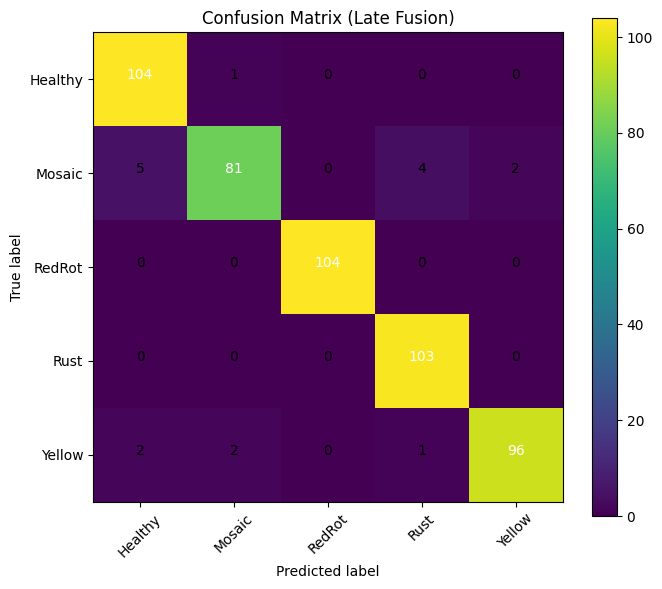

In [ ]:


# =========================
# 8) Metrics: Classification report & Confusion Matrix
# =========================
print("\n=== LATE FUSION (Normalized) — Classification Report ===")
print(classification_report(y_true_multi, y_pred_final, target_names=class_names, digits=4))

cm = confusion_matrix(y_true_multi, y_pred_final)
plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Late Fusion)")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

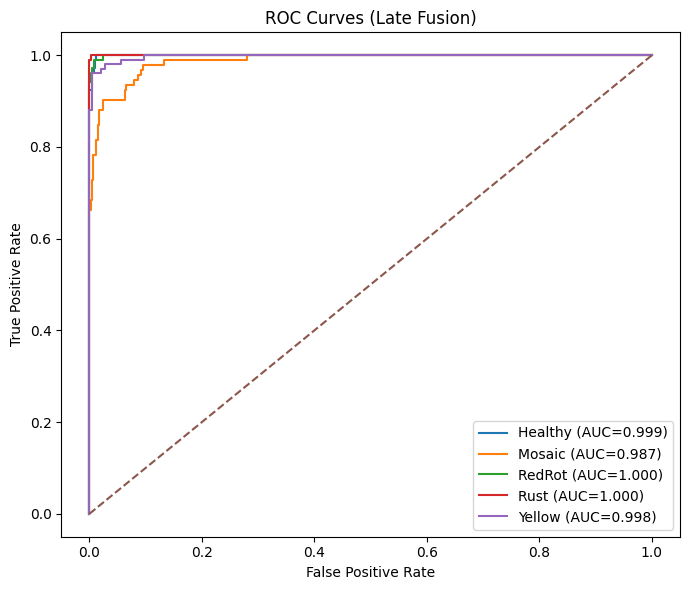

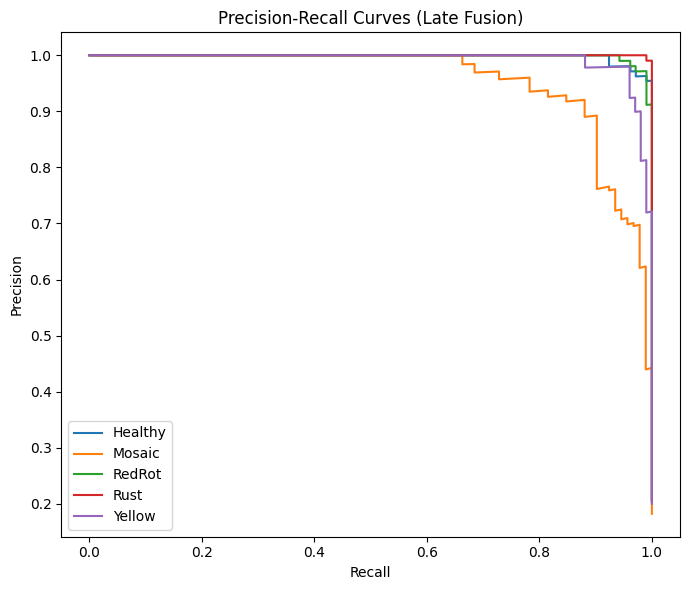

In [ ]:
# =========================
# 9) ROC & PR Curves per class (from late-fusion probabilities)
# =========================
# For ROC/PR, we need one-vs-rest scores per class. We'll use prob_matrix columns.
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_true_multi, classes=list(range(len(class_names))))  # [N,5]

# ROC curves + AUC
plt.figure(figsize=(7,6))
for i, cname in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], prob_matrix[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cname} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Late Fusion)")
plt.legend()
plt.tight_layout()
plt.show()

# Precision-Recall curves
plt.figure(figsize=(7,6))
for i, cname in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], prob_matrix[:, i])
    plt.plot(recall, precision, label=f"{cname}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (Late Fusion)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# =========================
# 10) (Optional) Save per-class models & fusion probabilities
# =========================
np.save("/content/ovr_prob_matrix.npy", prob_matrix)
print("Saved fusion probabilities -> /content/ovr_prob_matrix.npy")


In [ ]:
history = model.fit(train_data, train_labels,
                    validation_data=(val_data, val_labels),
                    epochs=50,
                    batch_size=32)


In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Suppose you stored results in lists
train_losses = []
val_losses = []
train_acc = []
val_acc = []

# during training loop you append to these lists

# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

# Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


#With Early Stoping
                 ┌───────────────┐
                 │   Input Leaf  │
                 │   Image (224) │
                 └───────┬───────┘
                         │
         ┌───────────────┼────────────────┐
         │               │                │
 ┌───────▼───────┐ ┌─────▼───────┐ ┌─────▼───────┐  (and so on)
 │   ResNet18    │ │   ResNet34  │ │   ResNet50  │ ... ResNet101, ResNet152
 └───────┬───────┘ └─────┬───────┘ └─────┬───────┘
         │               │                │
         ▼               ▼                ▼
   Softmax Prob.   Softmax Prob.    Softmax Prob.   ... (5 outputs)

         └───────────────┬──────────────────────┘
                         │
              ┌──────────▼──────────┐
              │   Late Fusion (avg) │
              └──────────┬──────────┘
                         │
                  ┌──────▼──────┐
                  │ Final Class │
                  │ Prediction  │
                  └─────────────┘


In [12]:
# ============================================
# OvR with 5 ResNet Backbones + Early Stopping
# Late-Fusion for 5-Class Plant Disease
# ============================================

import os, copy, time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize


In [13]:
# -------------------------
# Config
# -------------------------
data_dir = "/content/dataset"   # <- your extracted dataset root
class_names = ['Healthy','Mosaic','RedRot','Rust','Yellow']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Map each class to a different ResNet backbone
# You can change this mapping if you prefer different pairings
class_to_backbone = {
    'Healthy': 'resnet18',
    'Mosaic':  'resnet34',
    'RedRot':  'resnet50',
    'Rust':    'resnet101',
    'Yellow':  'resnet152',
}

# Training settings
batch_size = 32
epochs_max = 30
init_lr = 1e-4

# Early stopping settings
patience = 5       # stop if no improvement for N validation checks
min_delta = 1e-4   # minimal improvement (in val loss) to reset patience

# Where to save per-class weights
weights_dir = "/content/ovr_weights"
os.makedirs(weights_dir, exist_ok=True)


Device: cuda


In [14]:
# -------------------------
# Transforms & Base Dataset
# -------------------------
train_tfms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])


In [15]:
# ImageFolder expects your folder structure like:
# dataset/
#  ├─ Healthy/
#  ├─ Mosaic/
#  ├─ RedRot/
#  ├─ Rust/
#  └─ Yellow/
base_dataset = datasets.ImageFolder(root=data_dir, transform=eval_tfms)
assert base_dataset.classes == class_names, f"Found classes {base_dataset.classes}, expected {class_names}"

# Stratified splits (train/val/test = 64/16/20)
targets = np.array(base_dataset.targets)
indices = np.arange(len(base_dataset))

trainval_idx, test_idx = train_test_split(
    indices, test_size=0.20, stratify=targets, random_state=42
)
train_targets = targets[trainval_idx]
train_idx, val_idx = train_test_split(
    trainval_idx, test_size=0.20, stratify=train_targets, random_state=42
)

train_dataset = copy.copy(base_dataset)
val_dataset   = copy.copy(base_dataset)
test_dataset  = copy.copy(base_dataset)

train_dataset.transform = train_tfms
val_dataset.transform   = eval_tfms
test_dataset.transform  = eval_tfms

train_subset = Subset(train_dataset, train_idx)
val_subset   = Subset(val_dataset, val_idx)
test_subset  = Subset(test_dataset, test_idx)


In [16]:
# -------------------------
# OvR dataset wrapper
# -------------------------
class BinaryOvRDataset(Dataset):
    """Turn multiclass labels into binary (target_class vs rest)."""
    def __init__(self, subset, target_class_idx):
        self.subset = subset
        self.target_class_idx = target_class_idx

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, i):
        img, orig_label = self.subset[i]
        y = 1 if orig_label == self.target_class_idx else 0
        return img, torch.tensor(y, dtype=torch.long)

def make_loaders_for_class(target_class_idx, batch_size=32, num_workers=2):
    train_ds_bin = BinaryOvRDataset(train_subset, target_class_idx)
    val_ds_bin   = BinaryOvRDataset(val_subset, target_class_idx)
    test_ds_bin  = BinaryOvRDataset(test_subset, target_class_idx)

    train_loader = DataLoader(train_ds_bin, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(val_ds_bin,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test_ds_bin,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader, test_loader


In [17]:
# -------------------------
# Backbone builders (binary)
# -------------------------
def build_backbone(backbone_name: str) -> nn.Module:
    """Return a binary classifier (1 logit) using the given ResNet backbone."""
    if backbone_name == 'resnet18':
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    elif backbone_name == 'resnet34':
        m = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    elif backbone_name == 'resnet50':
        m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    elif backbone_name == 'resnet101':
        m = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2)
    elif backbone_name == 'resnet152':
        m = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V2)
    else:
        raise ValueError(f"Unknown backbone {backbone_name}")

    # Fine-tune last 2 residual stages + fc
    for name, p in m.named_parameters():
        if "layer3" in name or "layer4" in name or "fc" in name:
            p.requires_grad = True
        else:
            p.requires_grad = False

    in_features = m.fc.in_features
    m.fc = nn.Linear(in_features, 1)  # binary logit
    return m.to(device)

In [18]:
# -------------------------
# Train with Early Stopping
# -------------------------
def train_binary_model(model, train_loader, val_loader, epochs=30, lr=1e-4,
                       patience=5, min_delta=1e-4):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    best_val_loss = float('inf')
    best_weights = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    for epoch in range(1, epochs + 1):
        # ---- train ----
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x = x.to(device)
            y = y.float().unsqueeze(1).to(device)   # [B,1]
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # ---- validate ----
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.float().unsqueeze(1).to(device)
                logits = model(x)
                loss = criterion(logits, y)
                val_loss += loss.item()
        val_loss /= max(1, len(val_loader))

        print(f"Epoch {epoch:02d}/{epochs} | TrainLoss: {running_loss/len(train_loader):.4f} | ValLoss: {val_loss:.4f}")

        # ---- early stopping check (on val loss) ----
        if best_val_loss - val_loss > min_delta:
            best_val_loss = val_loss
            best_weights = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"⏹ Early stopping at epoch {epoch} (no improvement for {patience} checks)")
                break

    model.load_state_dict(best_weights)
    return model, best_val_loss


In [19]:
# -------------------------
# Train 5 OvR models (one per class/backbone)
# -------------------------
models_ovr = {}
for c_idx, c_name in enumerate(class_names):
    print(f"\n==============================")
    print(f"Training OvR for: {c_name}  | Backbone: {class_to_backbone[c_name]}")
    print(f"==============================")
    train_loader, val_loader, _ = make_loaders_for_class(c_idx, batch_size=batch_size)
    model_bin = build_backbone(class_to_backbone[c_name])
    model_bin, best_loss = train_binary_model(
        model_bin, train_loader, val_loader,
        epochs=epochs_max, lr=init_lr,
        patience=patience, min_delta=min_delta
    )
    save_path = os.path.join(weights_dir, f"{class_to_backbone[c_name]}_OvR_{c_name}.pth")
    torch.save(model_bin.state_dict(), save_path)
    print(f"✅ Saved best weights -> {save_path} | Best ValLoss: {best_loss:.4f}")
    model_bin.eval()
    models_ovr[c_name] = model_bin


Training OvR for: Healthy  | Backbone: resnet18
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 204MB/s]


Epoch 01/30 | TrainLoss: 0.3344 | ValLoss: 0.1156
Epoch 02/30 | TrainLoss: 0.1123 | ValLoss: 0.0810
Epoch 03/30 | TrainLoss: 0.0866 | ValLoss: 0.1117
Epoch 04/30 | TrainLoss: 0.0557 | ValLoss: 0.0838
Epoch 05/30 | TrainLoss: 0.0544 | ValLoss: 0.0746
Epoch 06/30 | TrainLoss: 0.0430 | ValLoss: 0.0634
Epoch 07/30 | TrainLoss: 0.0396 | ValLoss: 0.0382
Epoch 08/30 | TrainLoss: 0.0431 | ValLoss: 0.0487
Epoch 09/30 | TrainLoss: 0.0328 | ValLoss: 0.0499
Epoch 10/30 | TrainLoss: 0.0315 | ValLoss: 0.0575
Epoch 11/30 | TrainLoss: 0.0209 | ValLoss: 0.0683
Epoch 12/30 | TrainLoss: 0.0269 | ValLoss: 0.0631
⏹ Early stopping at epoch 12 (no improvement for 5 checks)
✅ Saved best weights -> /content/ovr_weights/resnet18_OvR_Healthy.pth | Best ValLoss: 0.0382

Training OvR for: Mosaic  | Backbone: resnet34
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 109MB/s]


Epoch 01/30 | TrainLoss: 0.2763 | ValLoss: 0.1521
Epoch 02/30 | TrainLoss: 0.1365 | ValLoss: 0.2348
Epoch 03/30 | TrainLoss: 0.1174 | ValLoss: 0.0929
Epoch 04/30 | TrainLoss: 0.0751 | ValLoss: 0.0723
Epoch 05/30 | TrainLoss: 0.0861 | ValLoss: 0.1072
Epoch 06/30 | TrainLoss: 0.0458 | ValLoss: 0.0970
Epoch 07/30 | TrainLoss: 0.0353 | ValLoss: 0.1089
Epoch 08/30 | TrainLoss: 0.0582 | ValLoss: 0.0932
Epoch 09/30 | TrainLoss: 0.0490 | ValLoss: 0.0652
Epoch 10/30 | TrainLoss: 0.0310 | ValLoss: 0.1044
Epoch 11/30 | TrainLoss: 0.0424 | ValLoss: 0.1254
Epoch 12/30 | TrainLoss: 0.0371 | ValLoss: 0.1085
Epoch 13/30 | TrainLoss: 0.0485 | ValLoss: 0.1364
Epoch 14/30 | TrainLoss: 0.0327 | ValLoss: 0.1484
⏹ Early stopping at epoch 14 (no improvement for 5 checks)
✅ Saved best weights -> /content/ovr_weights/resnet34_OvR_Mosaic.pth | Best ValLoss: 0.0652

Training OvR for: RedRot  | Backbone: resnet50
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/ch

100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]


Epoch 01/30 | TrainLoss: 0.3837 | ValLoss: 0.1834
Epoch 02/30 | TrainLoss: 0.1167 | ValLoss: 0.0614
Epoch 03/30 | TrainLoss: 0.0712 | ValLoss: 0.0489
Epoch 04/30 | TrainLoss: 0.0571 | ValLoss: 0.0646
Epoch 05/30 | TrainLoss: 0.0346 | ValLoss: 0.0492
Epoch 06/30 | TrainLoss: 0.0354 | ValLoss: 0.0771
Epoch 07/30 | TrainLoss: 0.0214 | ValLoss: 0.0796
Epoch 08/30 | TrainLoss: 0.0243 | ValLoss: 0.0558
⏹ Early stopping at epoch 8 (no improvement for 5 checks)
✅ Saved best weights -> /content/ovr_weights/resnet50_OvR_RedRot.pth | Best ValLoss: 0.0489

Training OvR for: Rust  | Backbone: resnet101
Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth


100%|██████████| 171M/171M [00:01<00:00, 112MB/s]


Epoch 01/30 | TrainLoss: 0.3159 | ValLoss: 0.1010
Epoch 02/30 | TrainLoss: 0.0713 | ValLoss: 0.0609
Epoch 03/30 | TrainLoss: 0.0455 | ValLoss: 0.0377
Epoch 04/30 | TrainLoss: 0.0165 | ValLoss: 0.0713
Epoch 05/30 | TrainLoss: 0.0330 | ValLoss: 0.0405
Epoch 06/30 | TrainLoss: 0.0298 | ValLoss: 0.0523
Epoch 07/30 | TrainLoss: 0.0189 | ValLoss: 0.0487
Epoch 08/30 | TrainLoss: 0.0075 | ValLoss: 0.0426
⏹ Early stopping at epoch 8 (no improvement for 5 checks)
✅ Saved best weights -> /content/ovr_weights/resnet101_OvR_Rust.pth | Best ValLoss: 0.0377

Training OvR for: Yellow  | Backbone: resnet152
Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


100%|██████████| 230M/230M [00:05<00:00, 48.1MB/s]


Epoch 01/30 | TrainLoss: 0.3165 | ValLoss: 0.1137
Epoch 02/30 | TrainLoss: 0.0785 | ValLoss: 0.0574
Epoch 03/30 | TrainLoss: 0.0611 | ValLoss: 0.0597
Epoch 04/30 | TrainLoss: 0.0537 | ValLoss: 0.0482
Epoch 05/30 | TrainLoss: 0.0299 | ValLoss: 0.0569
Epoch 06/30 | TrainLoss: 0.0290 | ValLoss: 0.0700
Epoch 07/30 | TrainLoss: 0.0248 | ValLoss: 0.0692
Epoch 08/30 | TrainLoss: 0.0334 | ValLoss: 0.0780
Epoch 09/30 | TrainLoss: 0.0210 | ValLoss: 0.0861
⏹ Early stopping at epoch 9 (no improvement for 5 checks)
✅ Saved best weights -> /content/ovr_weights/resnet152_OvR_Yellow.pth | Best ValLoss: 0.0482


In [20]:
# -------------------------
# Late Fusion on common test set
# -------------------------
plain_test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Collect probabilities for each class model over the same test samples
prob_matrix = []  # will be [N, 5]
with torch.no_grad():
    for c_name in class_names:
        model_c = models_ovr[c_name]
        probs_c = []
        for x, _ in plain_test_loader:
            x = x.to(device)
            logits = model_c(x)              # [B,1]
            p = torch.sigmoid(logits).squeeze(1)  # [B]
            probs_c.append(p.cpu().numpy())
        probs_c = np.concatenate(probs_c)        # [N]
        prob_matrix.append(probs_c)

prob_matrix = np.vstack(prob_matrix).T           # [N,5] columns in class_names order

# True multiclass labels
y_true_multi = []
for _, y in plain_test_loader:
    y_true_multi.append(y.numpy())
y_true_multi = np.concatenate(y_true_multi)      # [N,]

# Late fusion strategies
# 1) Normalize row-wise then argmax (often stabilizes OvR)
row_sums = prob_matrix.sum(axis=1, keepdims=True) + 1e-8
prob_norm = prob_matrix / row_sums
y_pred_final = np.argmax(prob_norm, axis=1)

# (Alternatives you can try)
# y_pred_argmax_raw = np.argmax(prob_matrix, axis=1)
# weights = np.ones(5)  # e.g. bias diseases vs healthy: np.array([0.9,1.05,1.05,1.05,1.0])
# y_pred_weighted = np.argmax(prob_matrix * weights.reshape(1,-1), axis=1)


=== LATE FUSION — Classification Report ===
              precision    recall  f1-score   support

     Healthy     0.9626    0.9810    0.9717       105
      Mosaic     0.9659    0.9239    0.9444        92
      RedRot     0.9905    1.0000    0.9952       104
        Rust     0.9619    0.9806    0.9712       103
      Yellow     0.9600    0.9505    0.9552       101

    accuracy                         0.9683       505
   macro avg     0.9682    0.9672    0.9675       505
weighted avg     0.9683    0.9683    0.9682       505



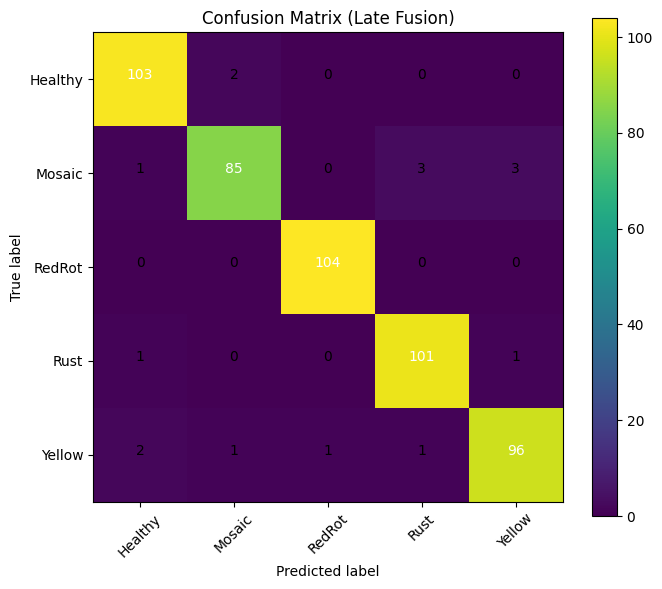

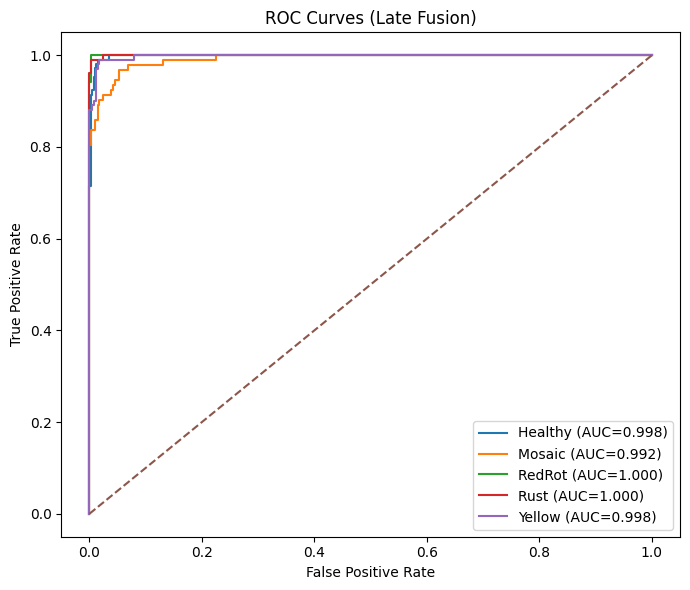

In [21]:
# -------------------------
# Metrics & Plots
# -------------------------
print("\n=== LATE FUSION — Classification Report ===")
print(classification_report(y_true_multi, y_pred_final, target_names=class_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true_multi, y_pred_final)
plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Late Fusion)")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# ROC Curves (OvR) using fused probabilities (per class column)
y_true_bin = label_binarize(y_true_multi, classes=list(range(len(class_names))))  # [N,5]

plt.figure(figsize=(7,6))
for i, cname in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], prob_matrix[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cname} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Late Fusion)")
plt.legend()
plt.tight_layout()
plt.show()

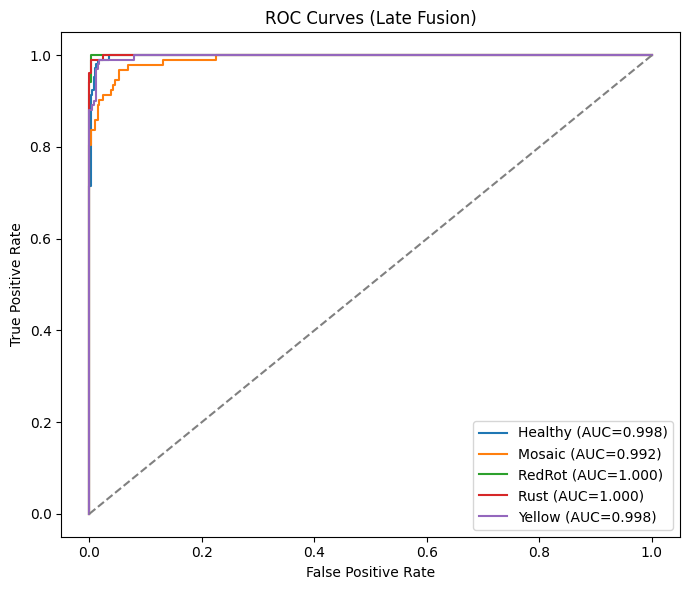

In [23]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_true_bin = label_binarize(y_true_multi, classes=list(range(len(class_names))))  # shape: [N, num_classes]

plt.figure(figsize=(7,6))
for i, cname in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], prob_matrix[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cname} (AUC={roc_auc:.3f})")

plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Late Fusion)")
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_true_multi, y_pred_final)
print("Overall Accuracy:", acc)


Overall Accuracy: 0.9683168316831683


In [25]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_true_multi, y_pred_final)
print("Cohen Kappa Score:", kappa)


Cohen Kappa Score: 0.9603647619187772


In [26]:
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_true_multi, y_pred_final)
print("Matthews Correlation Coefficient:", mcc)


Matthews Correlation Coefficient: 0.960426055204462


In [29]:
import torch
from torchvision import transforms
from PIL import Image
import os
import numpy as np

# -----------------------
# Settings
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['Healthy','Mosaic','RedRot','Rust','Yellow']
class_to_backbone = {
    'Healthy': 'resnet18',
    'Mosaic':  'resnet34',
    'RedRot':  'resnet50',
    'Rust':    'resnet101',
    'Yellow':  'resnet152',
}
weights_dir = "/content/ovr_weights"  # folder where your OvR model weights are stored

# -----------------------
# Load all 5 models
# -----------------------
def load_model(backbone_name, weight_path):
    if backbone_name == 'resnet18':
        model = models.resnet18(weights=None)
    elif backbone_name == 'resnet34':
        model = models.resnet34(weights=None)
    elif backbone_name == 'resnet50':
        model = models.resnet50(weights=None)
    elif backbone_name == 'resnet101':
        model = models.resnet101(weights=None)
    elif backbone_name == 'resnet152':
        model = models.resnet152(weights=None)
    else:
        raise ValueError(f"Unknown backbone {backbone_name}")

    in_features = model.fc.in_features
    model.fc = torch.nn.Linear(in_features,1)
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model.eval()
    return model.to(device)

models_ovr = {}
for cname in class_names:
    wpath = os.path.join(weights_dir, f"{class_to_backbone[cname]}_OvR_{cname}.pth")
    models_ovr[cname] = load_model(class_to_backbone[cname], wpath)

# -----------------------
# Image preprocessing (same as training)
# -----------------------
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# -----------------------
# Prediction function
# -----------------------
def predict_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)  # shape [1,3,224,224]

    probs = []
    with torch.no_grad():
        for cname in class_names:
            model = models_ovr[cname]
            logit = model(img_tensor)
            prob = torch.sigmoid(logit).item()
            probs.append(prob)

    probs = np.array(probs)
    pred_idx = np.argmax(probs)       # class with highest probability
    pred_class = class_names[pred_idx]
    return pred_class, probs

# -----------------------
# Evaluate folder of unseen images
# -----------------------
# unseen_folder = "/content/unseen_images"  # path to your new images
# for fname in os.listdir(unseen_folder):
#     fpath = os.path.join(unseen_folder, fname)
#     pred_class, probs = predict_image(fpath)
#     print(f"{fname} -> Predicted: {pred_class} | Probabilities: {probs}")


In [36]:
# Path to your single unseen image
image_path = "/content/sugaecane111.jpg"
# Predict class
pred_class, probs = predict_image(image_path)

print(f"Predicted Class: {pred_class}")
print(f"Class Probabilities: {dict(zip(class_names, probs))}")


Predicted Class: Healthy
Class Probabilities: {'Healthy': np.float64(0.9980950951576233), 'Mosaic': np.float64(0.003711323719471693), 'RedRot': np.float64(0.03372884914278984), 'Rust': np.float64(0.21450702846050262), 'Yellow': np.float64(0.18062171339988708)}


In [31]:
import numpy as np

# Original probs from OvR models
probs_dict = {'Healthy': 0.0009967, 'Mosaic': 0.0001312, 'RedRot': 0.2216678,
              'Rust': 0.1852080, 'Yellow': 0.2560834}

# Convert to array
probs_arr = np.array(list(probs_dict.values()))

# Normalize so sum = 1
probs_norm = probs_arr / probs_arr.sum()

# Map back to class names
probs_norm_dict = dict(zip(probs_dict.keys(), probs_norm))
pred_class = max(probs_norm_dict, key=probs_norm_dict.get)

print("Normalized Probabilities:", probs_norm_dict)
print("Predicted Class (highest prob):", pred_class)


Normalized Probabilities: {'Healthy': np.float64(0.001500857342357652), 'Mosaic': np.float64(0.00019756444598908787), 'RedRot': np.float64(0.3337932629620422), 'Rust': np.float64(0.27889112738374233), 'Yellow': np.float64(0.38561718786586885)}
Predicted Class (highest prob): Yellow


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve
import seaborn as sns
from sklearn.preprocessing import label_binarize


In [ ]:
data_dir = "/content/dataset"

# Train augmentations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3), # helps with Healthy vs Yellow
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Validation/test transforms
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Datasets
train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(root=data_dir, transform=test_transforms)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pretrained ResNet18
model = models.resnet18(pretrained=True)

# Unfreeze last 2 layers (layer3, layer4, fc)
for name, param in model.named_parameters():
    if "layer4" in name or "layer3" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Replace classifier
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)


In [ ]:
num_epochs = 15
train_losses, test_losses, accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    test_losses.append(val_loss / len(test_loader))
    accuracies.append(acc)

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"Train Loss: {running_loss/len(train_loader):.4f} "
          f"Val Loss: {val_loss/len(test_loader):.4f} "
          f"Val Acc: {acc:.2f}%")


Epoch 1/15 Train Loss: 0.5407 Val Loss: 0.1541 Val Acc: 94.84%
Epoch 2/15 Train Loss: 0.1987 Val Loss: 0.0802 Val Acc: 97.14%
Epoch 3/15 Train Loss: 0.1358 Val Loss: 0.0606 Val Acc: 98.02%
Epoch 4/15 Train Loss: 0.1100 Val Loss: 0.0416 Val Acc: 98.73%
Epoch 5/15 Train Loss: 0.0820 Val Loss: 0.0438 Val Acc: 98.41%
Epoch 6/15 Train Loss: 0.0912 Val Loss: 0.0351 Val Acc: 98.65%
Epoch 7/15 Train Loss: 0.0826 Val Loss: 0.0201 Val Acc: 99.33%
Epoch 8/15 Train Loss: 0.0795 Val Loss: 0.0250 Val Acc: 99.17%
Epoch 9/15 Train Loss: 0.0479 Val Loss: 0.0213 Val Acc: 99.44%
Epoch 10/15 Train Loss: 0.0562 Val Loss: 0.0147 Val Acc: 99.60%
Epoch 11/15 Train Loss: 0.0497 Val Loss: 0.0172 Val Acc: 99.72%
Epoch 12/15 Train Loss: 0.0407 Val Loss: 0.0161 Val Acc: 99.60%
Epoch 13/15 Train Loss: 0.0597 Val Loss: 0.0148 Val Acc: 99.68%
Epoch 14/15 Train Loss: 0.0446 Val Loss: 0.0099 Val Acc: 99.80%
Epoch 15/15 Train Loss: 0.0300 Val Loss: 0.0068 Val Acc: 99.88%


Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       522
      Mosaic       1.00      1.00      1.00       462
      RedRot       1.00      1.00      1.00       518
        Rust       1.00      1.00      1.00       514
      Yellow       1.00      1.00      1.00       505

    accuracy                           1.00      2521
   macro avg       1.00      1.00      1.00      2521
weighted avg       1.00      1.00      1.00      2521



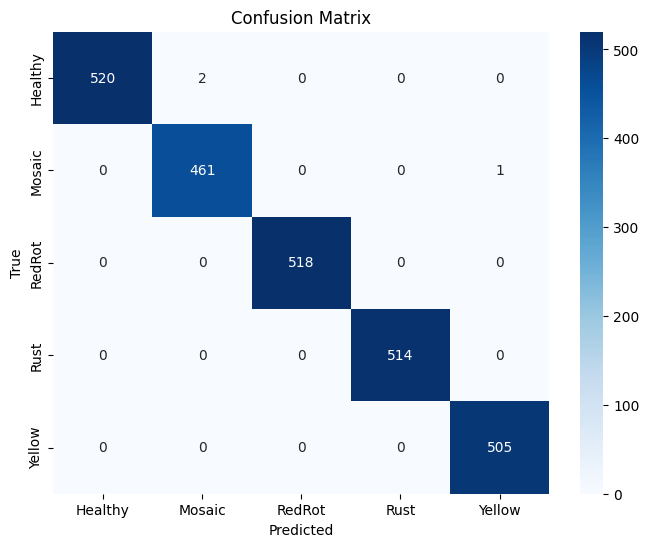

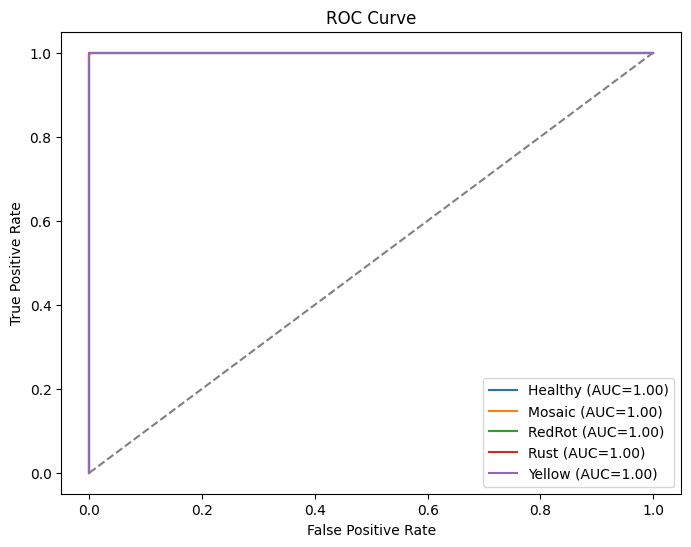

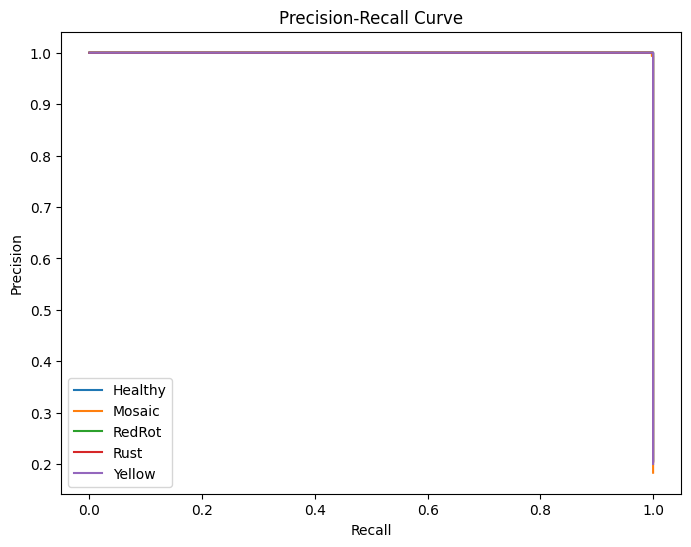

In [ ]:
# Collect predictions
y_true, y_pred, y_prob = [], [], []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix Heatmap
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve + AUC
y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
n_classes = y_true_bin.shape[1]

plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], np.array(y_prob)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(8,6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], np.array(y_prob)[:, i])
    plt.plot(recall, precision, label=f"{class_names[i]}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()
